<a href="https://colab.research.google.com/github/rnjsdn12332/comic2pic/blob/main/sketch2pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Custom dataset
from PIL import Image
import torch.utils.data as data
import os
import random


class DatasetFromFolder(data.Dataset):
    def __init__(self, path2img, direction='AtoB', transform=False): #b2a : binary to ascii
        super().__init__()
        self.direction = direction
        self.path2a = 'C:/Users/Mobile/Desktop/woo/pix2pix-master/pix2pix-master/data/sample_pattern'
        self.path2b = 'C:/Users/Mobile/Desktop/woo/pix2pix-master/pix2pix-master/data/sample_convert'
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'AtoB':
            return a,b
        else:
            return b,a

    def __len__(self):
        return len(self.img_filenames)

In [ ]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
# import scipy.misc
import matplotlib.pyplot as plt

try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO  # Python 3.x


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            # scipy.misc.toimage(img).save(s, format="png")
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [ ]:
import torch


class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)


class Generator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator128, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv5 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv6 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv7 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc7)
        dec1 = torch.cat([dec1, enc6], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc5], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc4], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc3], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc2], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc1], 1)
        dec7 = self.deconv7(dec6)
        out = torch.nn.Tanh()(dec7)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8, stride=1)
        self.conv5 = ConvBlock(num_filter * 8, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)


class Discriminator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator128, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4, stride=1)
        self.conv4 = ConvBlock(num_filter * 4, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)

In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os



# For logger
def to_np(x):
    return x.data.cpu().numpy()


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


# Plot losses
def plot_loss(d_losses, g_losses, num_epochs, save=False, save_dir='results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Loss_values_epoch_{:d}'.format(num_epochs) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_test_result(input, target, gen_image, epoch, training=True, save=False, save_dir='results/', show=False, fig_size=(5, 5)):
    if not training:
        fig_size = (input.size(2) * 3 / 100, input.size(3)/100)

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if training:
            save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = save_dir + 'Test_result_{:d}'.format(epoch+1) + '.png'
            fig.subplots_adjust(bottom=0)
            fig.subplots_adjust(top=1)
            fig.subplots_adjust(right=1)
            fig.subplots_adjust(left=0)
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


# Make gif
def make_gif(dataset, num_epochs, save_dir='results/'):
    gen_image_plots = []
    for epoch in range(num_epochs):
        # plot for generating gif
        save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch + 1) + '.png'
        gen_image_plots.append(imageio.imread(save_fn))

    imageio.mimsave(save_dir + dataset + '_pix2pix_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)


In [ ]:
print(os.getcwd())
import torch, gc
gc.collect()
torch.cuda.empty_cache()

C:\Users\Mobile\Desktop\woo\pix2pix-master\pix2pix-master


In [ ]:
def generate_image(G, x_, y_):
    G.eval()
    test_images = G(x_.squeeze(0))

    size_figure_grid = 3
    fig, ax = plt.subplots(1, size_figure_grid, figsize=(10, 4))
    for j in range(size_figure_grid):
        ax[j].get_xaxis().set_visible(False)
        ax[j].get_yaxis().set_visible(False)

    ax[0].cla()
    ax[0].imshow((x_.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    ax[1].cla()
    ax[1].imshow((test_images[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    ax[2].cla()
    ax[2].imshow((y_.cpu().numpy().transpose(1, 2, 0) + 1) / 2)

    plt.show()

1050
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.000

(-0.5, 255.5, 255.5, -0.5)

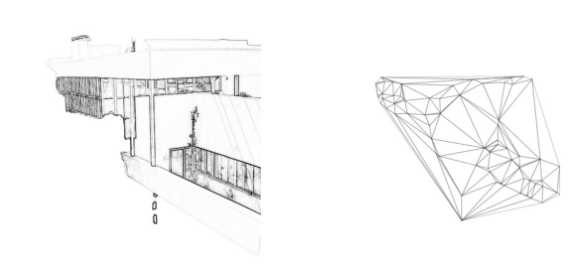

In [ ]:
from PIL import ImageFile
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from os import listdir
from os.path import join
# Data pre-processing
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                transforms.Resize((256,256))])

# Train data
data_dir ='./data/'
test_dir='./data/test/'
train_data = DatasetFromFolder(data_dir, direction="BtoA", transform=transform
                               )
train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=32,
                                                shuffle=True)


test_data=DatasetFromFolder(test_dir, direction="BtoA",transform=transform)


print(len(train_data))
a,b = train_data[0]
print(train_data[0][0])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(a*0.5 + 0.5)) #tensor 데이터를 pil데이터로 변환

plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')


In [ ]:
from os import listdir
from os.path import join
import torch
from torchvision import transforms
from torch.autograd import Variable
import argparse
import os

# Directories for loading data and saving results
data_dir ='./data/'
save_dir = 'results/'
model_dir = 'model/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Data pre-processing
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                transforms.Resize((256,256))])

# Train data
train_data = DatasetFromFolder(data_dir, direction="AtoB", transform=transform
                               )
train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=32,
                                                shuffle=True)



test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=2,
                                               shuffle=False)
test_input, test_target = test_data_loader.__iter__().__next__()
# Models
G = Generator(3, 64, 3)
D = Discriminator(6, 64, 1)
G.cuda()
D.cuda()
G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)



# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(50):
    D_losses = []
    G_losses = []

    # training
    for input, target in train_data_loader:

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = 100* L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, 50, step, len(train_data_loader), D_loss.data.item(), G_loss.data.item()))

        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Show result for test image
    

    



# Save trained parameters of model
torch.save(G.state_dict(), model_dir + 'generator_param.pkl')
torch.save(D.state_dict(), model_dir + 'discriminator_param.pkl')





C:\Users\Mobile\AppData\Local\Temp/ipykernel_29220/1730421462.py:102: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
C:\Users\Mobile\AppData\Local\Temp/ipykernel_29220/1730421462.py:104: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)
C:\Users\Mobile\AppData\Local\Temp/ipykernel_29220/1730421462.py:185: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.00 GiB total capacity; 3.37 GiB already allocated; 0 bytes free; 4.30 GiB reserved in total by PyTorch)

In [ ]:
# evaluation model
G.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in test_data_loader:
        fake_imgs = G(a.cuda().data).detach().cpu()
        real_imgs = b
        picture_imgs = a
        print(1)
# 가짜 이미지 시각화




In [ ]:
plt.figure(figsize=(10,10))

for ii in range(0,9,3):
    plt.subplot(3,3,ii+1)
    plt.imshow(to_pil_image(0.5*picture_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(3,3,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(3,3,ii+3)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')